# August stim analysis, 2021

**Motivation**: Stim play (stim times) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
mode = 'bold'
metric = 'pearson'
match_metric = 'cosine'

task = 'led'
mice = Mice(Config(512, normalization='none'), load_df=True, load_preproc=True)
mice.combine_dfs(task, full=True)

[PROGRESS] 'bold.df' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-none_parcel-spatial-sym_n-512

Warning! NaN detected:  sub, ses, run = 8, 1, 1

Warning! NaN detected:  sub, ses, run = 10, 2, 1

[PROGRESS] 'bold.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-none_parcel-spatial-sym_n-512

In [3]:
region_overlap = mice.parcel.get_region_overlap()

include = {}
for region, x in region_overlap.items():
    if 'VIS' in x and region <= mice.cfg.n_cortex_regions // 2:
        # print(region, x)
        include[region] = x
include

  0%|          | 0/512 [00:00<?, ?it/s]

{
    196: {'PTLp': 80.0, 'VIS': 20.0},
    199: {'VIS': 93.0},
    204: {'VIS': 76.0, 'PTLp': 24.0},
    205: {'VIS': 52.0, 'SS': 29.0, 'SSp': 26.0, 'SSp-bfd': 26.0},
    210: {'RSP': 75.0, 'VIS': 25.0},
    211: {'VIS': 100.0},
    217: {'VIS': 79.0, 'PTLp': 21.0},
    218: {'VIS': 54.0, 'AUD': 45.0},
    219: {'VIS': 100.0},
    222: {'VIS': 100.0},
    224: {'VIS': 100.0},
    225: {'VIS': 97.0},
    227: {'VIS': 100.0},
    230: {'VIS': 100.0},
    233: {'VIS': 60.0, 'RSP': 40.0},
    235: {'VIS': 71.0, 'TEa': 29.0},
    236: {'VIS': 100.0},
    238: {'VIS': 100.0},
    239: {'VIS': 100.0},
    240: {'TEa': 79.0, 'VIS': 21.0},
    241: {'VIS': 100.0},
    243: {'VIS': 100.0},
    244: {'VIS': 100.0},
    245: {'VIS': 100.0},
    246: {'TEa': 55.0, 'VIS': 32.0},
    248: {'VIS': 100.0},
    249: {'VIS': 100.0},
    250: {'VIS': 80.0},
    251: {'VIS': 100.0},
    252: {'VIS': 100.0},
    253: {'RSP': 77.0, 'VIS': 23.0},
    254: {'VIS': 85.0},
    255: {'VIS': 100.0},
    256: {'VIS': 100.0}
}

In [4]:
delay = 10
extent = 15
dlist = []
ctr = 0
all_baselines = []
for sub in tqdm(range(1, 11)):
    for ses in range(1, 4):
        for run in range(1, 8):
            _df = mice.bold_df
            _df = _df.loc[
                (_df.subject == sub) &
                (_df.session == ses) &
                (_df.run == run)
            ]
            if not _df.stim.sum():
                continue

            # print(sub, ses, run, _df.stim.sum())

            for i in include:
                df_l = _df.loc[_df.region_id == f"0-315-{i}"]
                df_r = _df.loc[_df.region_id == f"1-315-{i + mice.cfg.n_cortex_regions // 2}"]
                stim = df_r.stim.values
                stim_on = [
                    idx + 1 for idx, (i, j)
                    in enumerate(zip(stim[:-1], stim[1:]))
                    if i - j == -1
                ]
                stim_off = [
                    idx for idx, (i, j)
                    in enumerate(zip(stim[:-1], stim[1:]))
                    if i - j == 1
                ]

                x_l = df_l.bold.values
                x_r = df_r.bold.values
                x_l = sp_stats.zscore(x_l)
                x_r = sp_stats.zscore(x_r)

                for on in stim_on:
                    for cond in ['on', 'off', 'full']:
                        if cond == 'full':
                            continue

                        if cond == 'on':
                            intvl = range(on - delay, on + extent)
                            # base_int = range(on - baseline, on)
                        elif cond == 'off':
                            intvl = range(on - delay - extent, on)
                            # base_int = range(on - extent - baseline, on - extent)
                        else:
                            intvl = range(on, on + 2 * extent)

                        for hemis in ['left', 'right']:
                            x = x_l.copy() if hemis == 'left' else x_r.copy()
                            try:
                                x_main = x[intvl]
                            except IndexError:
                                continue

                            baseline = x_main[:delay].mean()
                            x_main -= baseline
                            # x_main = (x_main - baseline) / baseline
                            # x_main -= baseline
                            all_baselines.append(baseline)
                            # x_main *= 100
                            # if cond == 'full':
                            # _x = sp_stats.zscore(_x)
                            
                            ctr += 1

                            data_dict = {
                                'sub': [sub] * len(intvl),
                                'ses': [ses] * len(intvl),
                                'run': [run] * len(intvl),
                                'region': [i] * len(intvl),
                                't_on': [on] * len(intvl),
                                't': range(len(intvl)),
                                'cond': [cond] * len(intvl),
                                'hemis': [hemis] * len(intvl),
                                'response': x_main,
                            }
                            dlist.append(data_dict)
data = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
ctr

96696

In [7]:
28440 / 10 / len(include)

83.6470588235294

<AxesSubplot:ylabel='Count'>

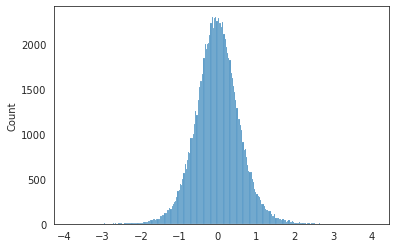

In [8]:
sns.histplot(all_baselines)

In [9]:
# collections.Counter(data.t_on)

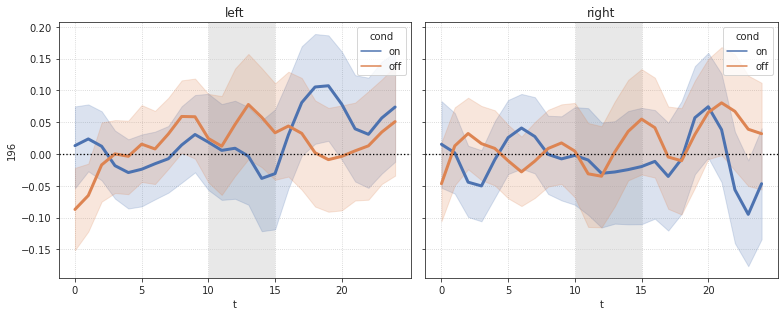

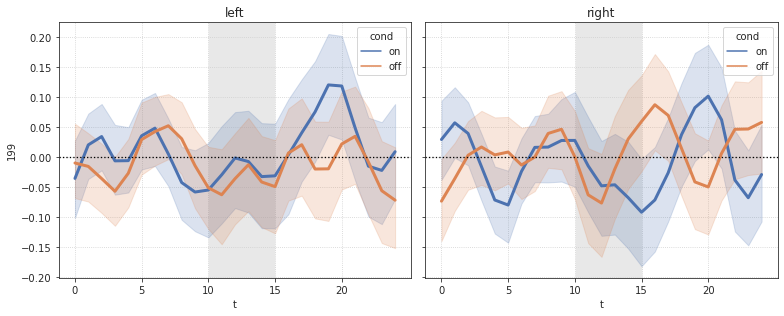

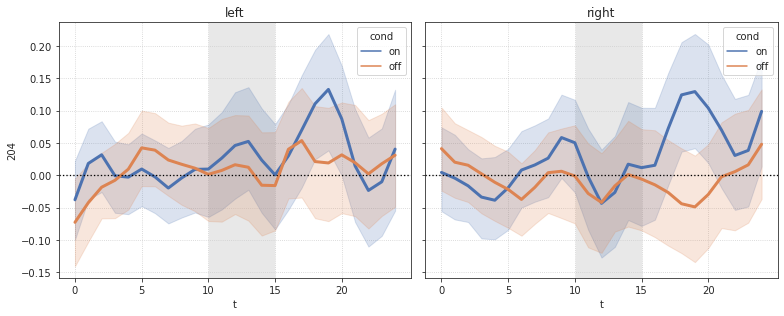

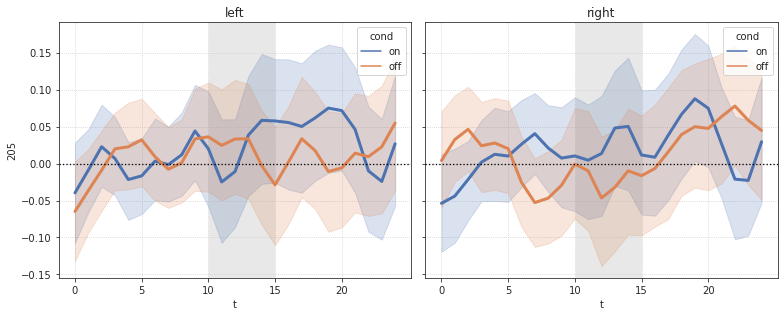

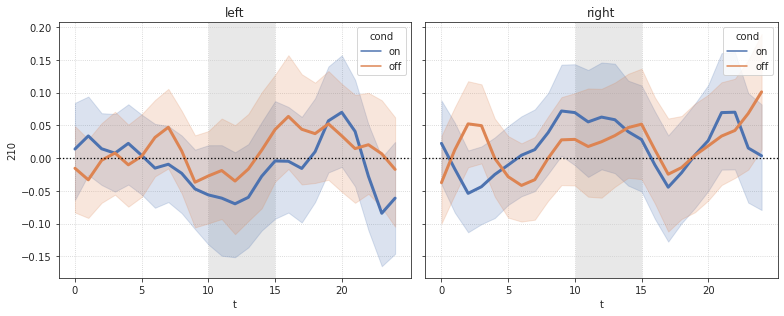

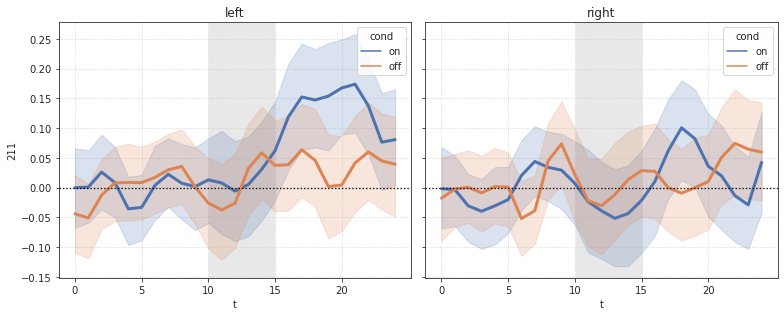

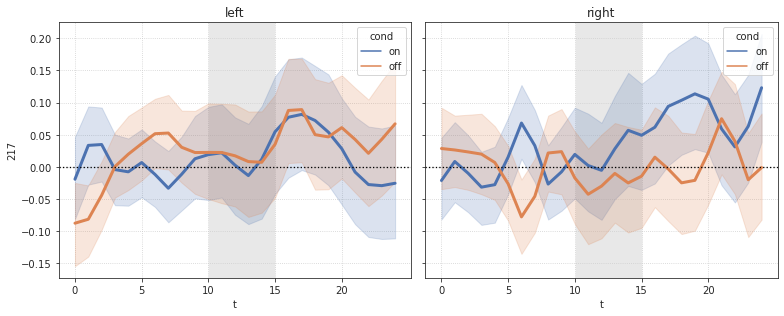

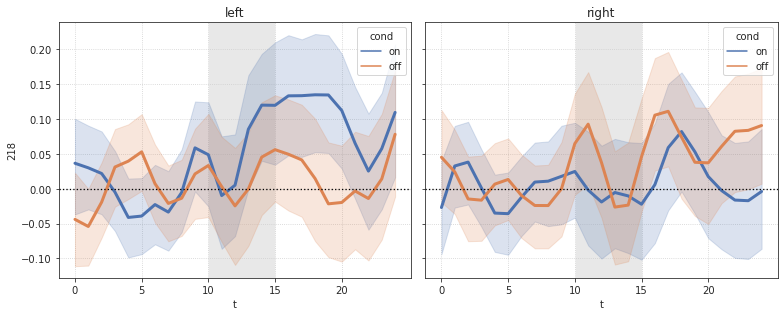

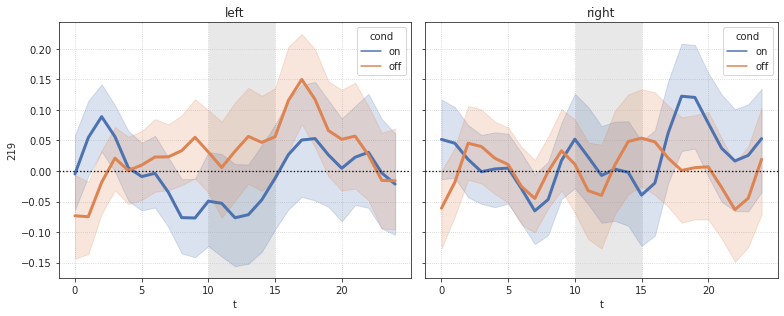

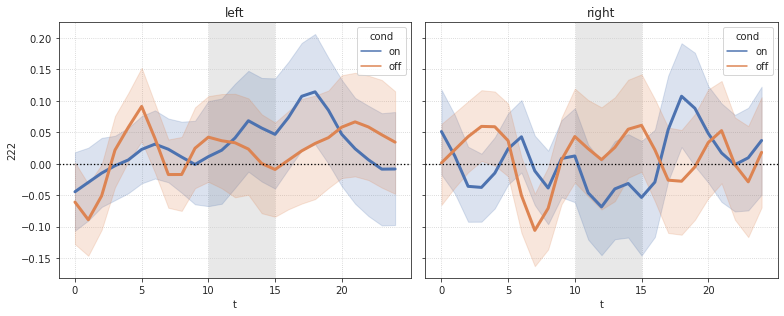

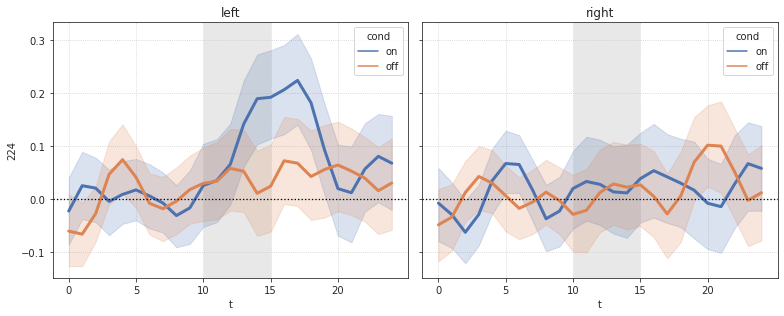

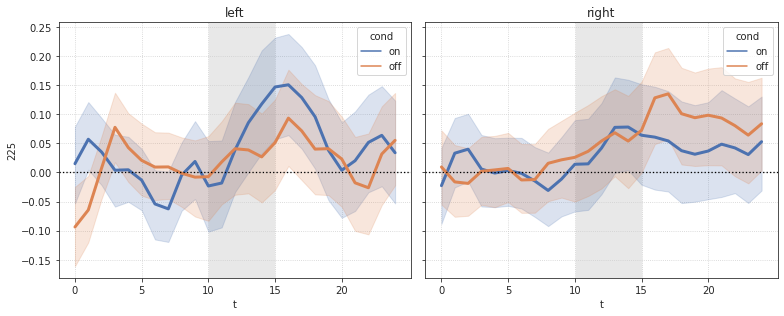

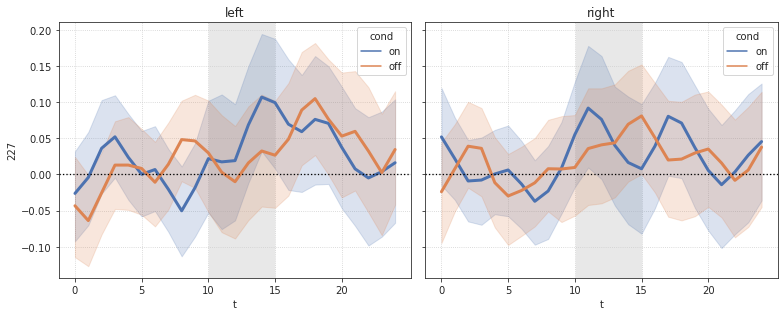

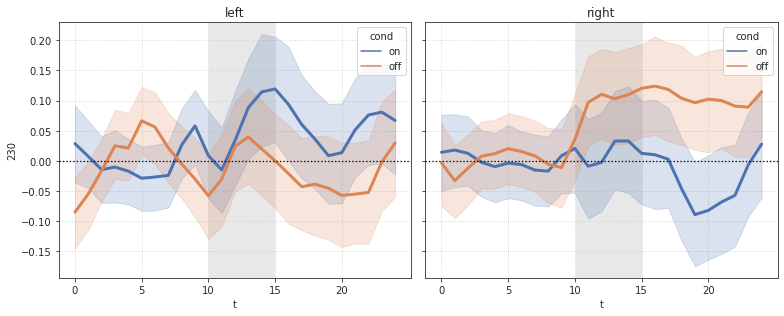

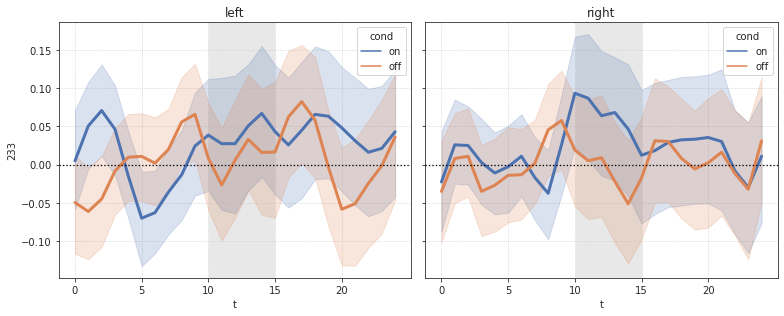

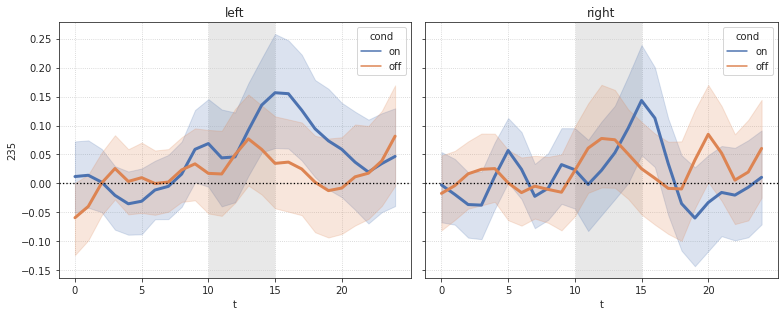

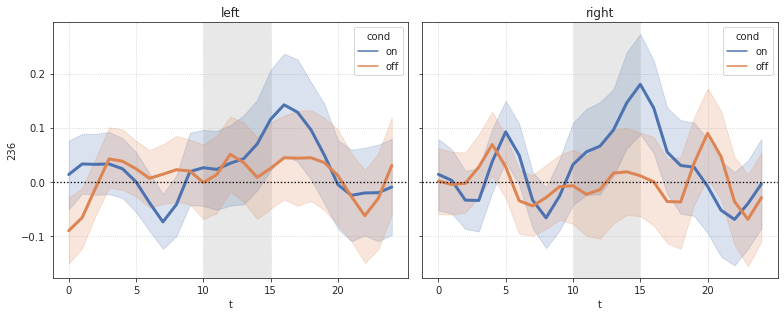

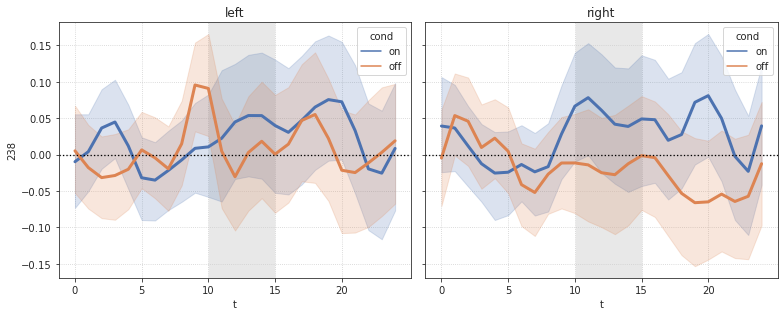

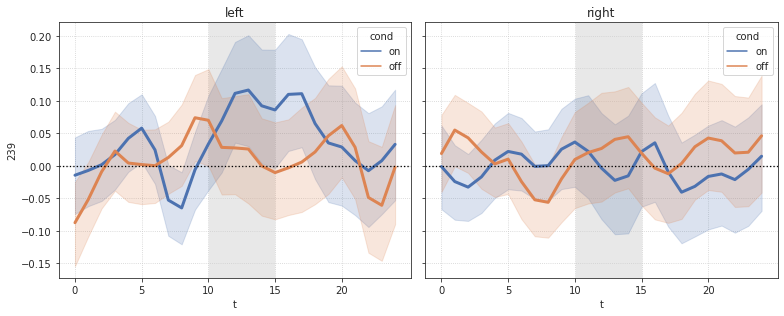

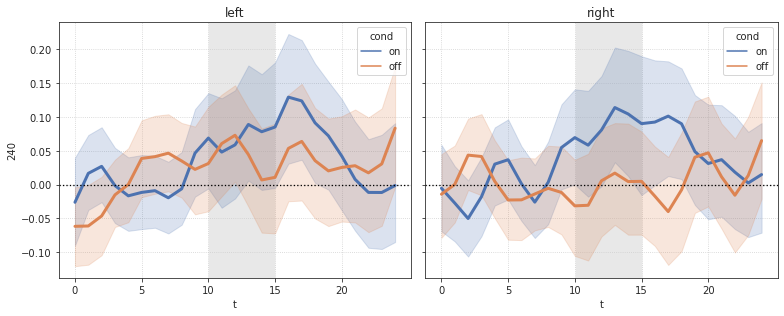

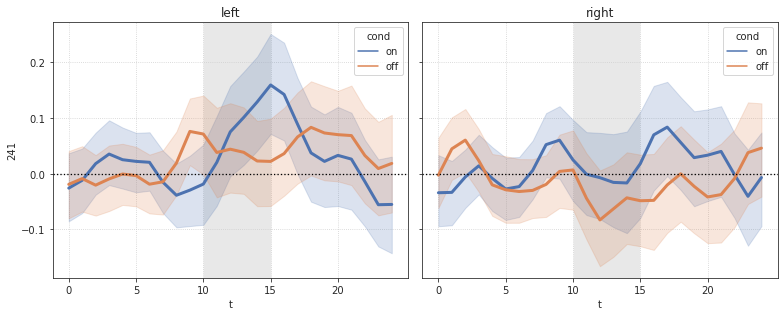

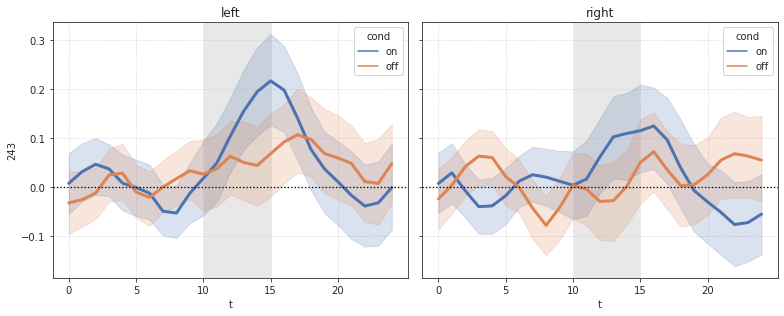

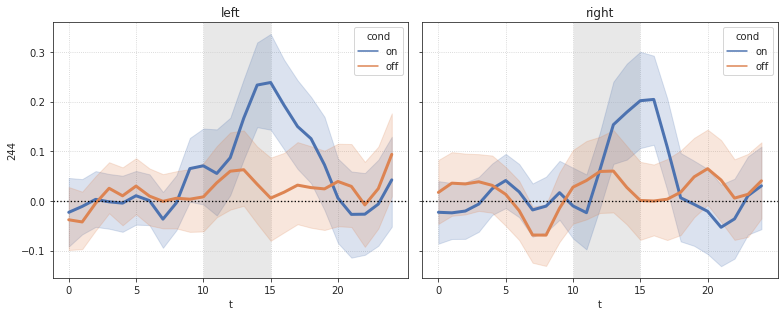

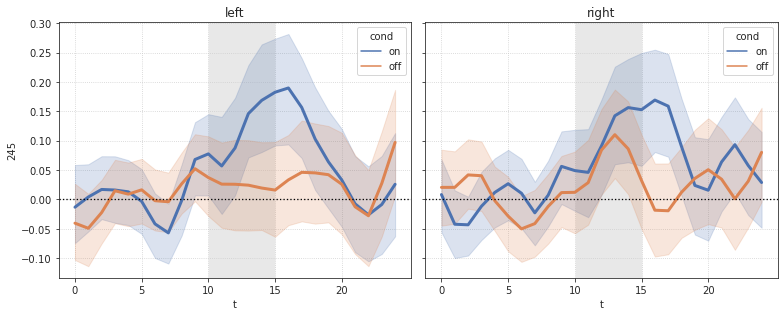

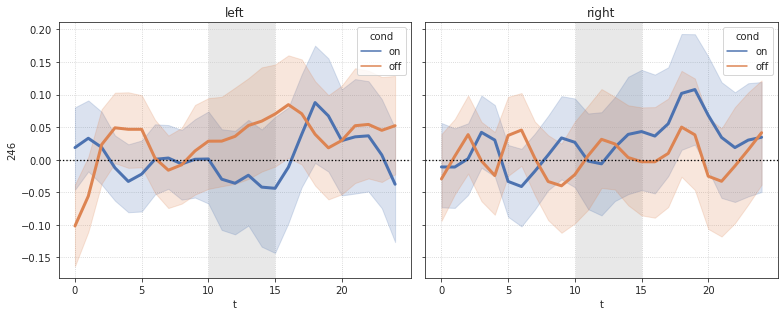

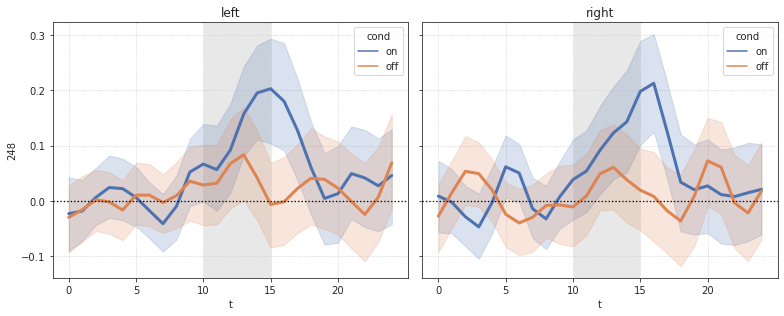

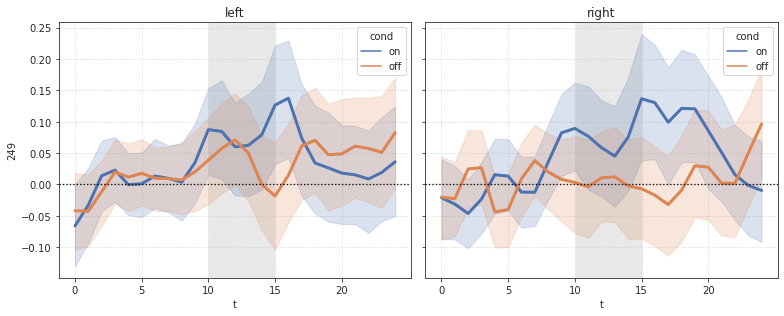

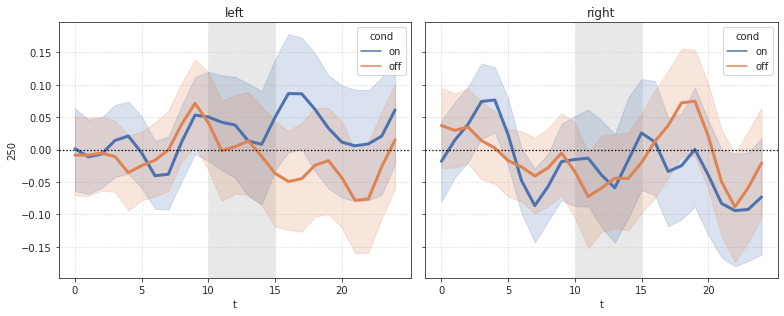

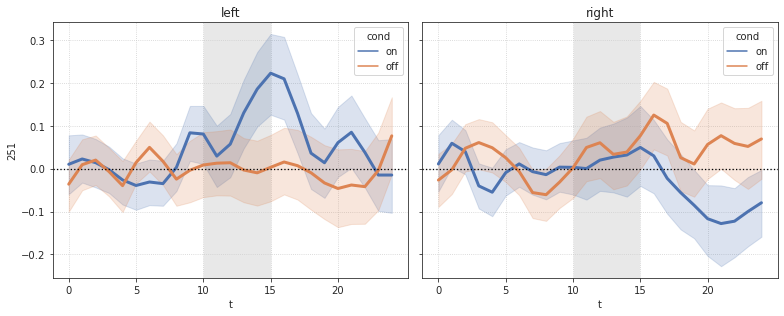

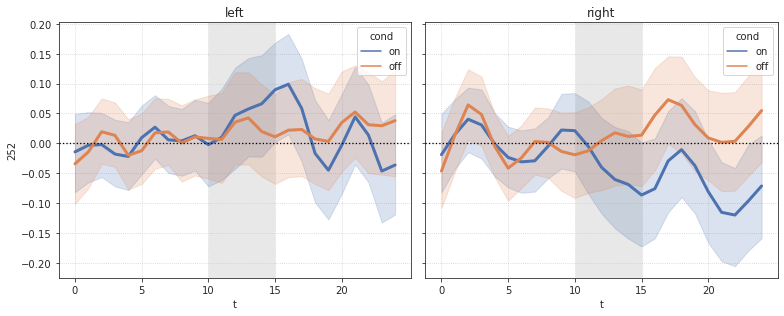

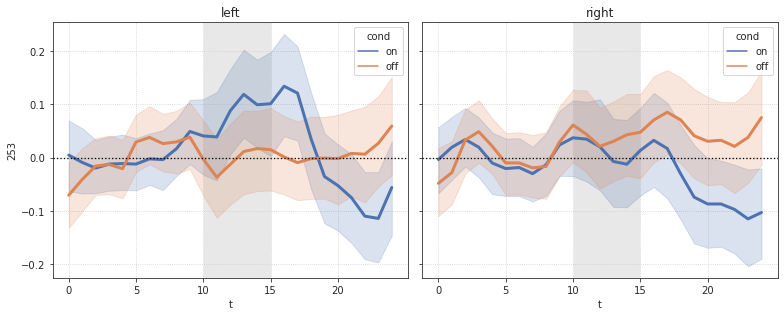

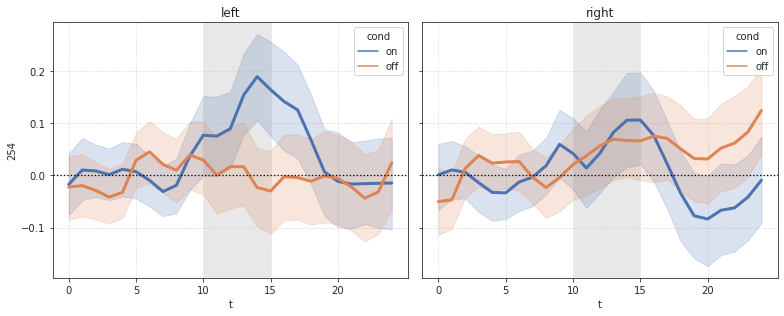

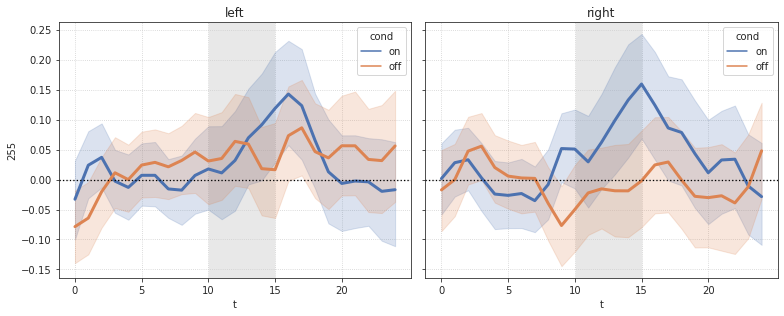

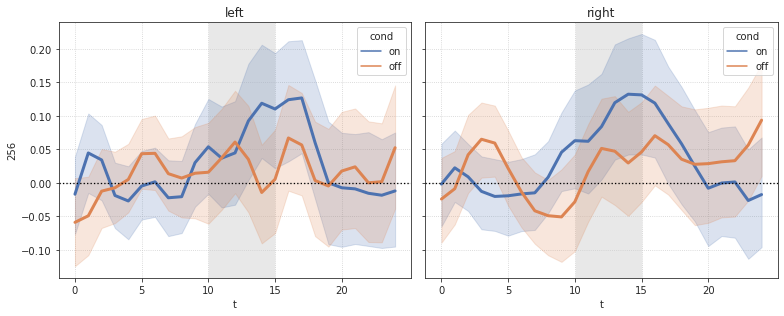

In [10]:
for region in include:

    fig, axes = create_figure(1, 2, (11, 4.5), 'ticks', 'all', 'all')
    for ax, lr in zip(axes, ['left', 'right']):
        sns.lineplot(
            data=data.loc[(data.hemis == lr) & (data.region == region)],
            x='t',
            y='response',
            hue='cond',
            palette='deep',
            lw=3,
            ax=ax,
        )
        ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.5, zorder=0)
        ax.axhline(0, color='k', ls=':', lw=1.3)
        ax.set(xticks=range(0, extent + delay, 5), title=lr)
        if lr == 'left':
            ax.set_ylabel(region)
        ax.grid(linestyle=':')
    plt.show()

In [11]:
fig, axes = create_figure(len(include), 2, (12.5, 4.3 * len(include)), 'ticks', 'all', 'row')

for i, region in enumerate(include):
    for ax, lr in zip(axes[i], ['left', 'right']):
        sns.lineplot(
            data=data.loc[(data.hemis == lr) & (data.region == region)],
            x='t',
            y='response',
            hue='cond',
            palette='deep',
            ci=95,
            lw=3,
            ax=ax,
        )
        ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.6, zorder=0)
        ax.axhline(0, color='k', ls=':', lw=1.3)
        ax.set(xticks=range(0, extent + delay, 5), title=lr)
        if lr == 'left':
            ylabel = f"ROI # {region}\n{include[region]}\n\n"
            ylabel += r"Normalized Sig. Intensity ± 95%"
            ax.set_ylabel(ylabel, fontsize=14)
        ax.grid(linestyle=':')
        
        if i == 0:
            ax.set_title(lr, y=1.05, fontsize=20)

fig.savefig(pjoin(tmp_dir, 'stim.pdf'), bbox_inches='tight')
plt.close()

In [12]:
nrows = 10
fig, axes = create_figure(nrows, 2, (12.5, 4.3 * nrows), 'ticks', 'all', 'row')

region = 248
ci = 68

for i, sub in enumerate(mice.cfg.sub_ids):
    for ax, lr in zip(axes[i], ['left', 'right']):
        sns.lineplot(
            data=data.loc[
                (data.hemis == lr) &
                (data.region == region) &
                (data.loc[:, 'sub'] == sub)
            ],
            x='t',
            y='response',
            hue='cond',
            palette='deep',
            ci=ci,
            lw=3,
            ax=ax,
        )
        ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.6, zorder=0)
        ax.axhline(0, color='k', ls=':', lw=1.3)
        ax.set(xticks=range(0, extent + delay, 5), title=lr)
        if lr == 'left':
            ylabel = f"Mouse # {sub}.\nROI # {region}\n{include[region]}\n\n"
            ylabel += f"Normalized Sig. Intensity ± {ci}%"
            ax.set_ylabel(ylabel, fontsize=14)
        ax.grid(linestyle=':')
        
        if i == 0:
            ax.set_title(lr, y=1.05, fontsize=20)

fig.savefig(pjoin(tmp_dir, f"stim_mouse_ROI{region}.pdf"), bbox_inches='tight')
plt.close()

In [13]:
nrows = 10
fig, axes = create_figure(nrows, 2, (12.5, 4.3 * nrows), 'ticks', 'all', 'row')

region = 251
ci = 68

for i, sub in enumerate(mice.cfg.sub_ids):
    for ax, lr in zip(axes[i], ['left', 'right']):
        sns.lineplot(
            data=data.loc[
                (data.hemis == lr) &
                (data.region == region) &
                (data.loc[:, 'sub'] == sub)
            ],
            x='t',
            y='response',
            hue='cond',
            palette='deep',
            ci=95,
            lw=3,
            ax=ax,
        )
        ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.6, zorder=0)
        ax.axhline(0, color='k', ls=':', lw=1.3)
        ax.set(xticks=range(0, extent + delay, 5), title=lr)
        if lr == 'left':
            ylabel = f"Mouse # {sub}.\nROI # {region}\n{include[region]}\n\n"
            ylabel += f"Normalized Sig. Intensity ± {ci}%"
            ax.set_ylabel(ylabel, fontsize=14)
        ax.grid(linestyle=':')
        
        if i == 0:
            ax.set_title(lr, y=1.05, fontsize=20)

fig.savefig(pjoin(tmp_dir, f"stim_mouse_ROI{region}.pdf"), bbox_inches='tight')
plt.close()

In [ ]:
i = 63
df_l = _df.loc[_df.region_id == f"0-315-{i}"]
df_r = _df.loc[_df.region_id == f"1-315-{i+64}"]

x_l = df_l.bold.values
x_r = df_r.bold.values

x_l = sp_stats.zscore(x_l)
x_r = sp_stats.zscore(x_r)

stim = df_l.stim.values

In [ ]:
plt.plot(stim)

In [ ]:
stim_on = [idx + 1 for idx, (i, j) in enumerate(zip(stim[:-1], stim[1:])) if i - j == -1]
stim_off = [idx for idx, (i, j) in enumerate(zip(stim[:-1], stim[1:])) if i - j == 1]

In [ ]:
stim_on, stim_off

In [ ]:
stim[stim_on[0]:stim_on[0] + 10]

In [ ]:
stim[stim_on[1]:stim_on[1] + 10]

In [ ]:
plt.figure(figsize=(50, 4))
plt.plot(x_l)
plt.plot(x_r)

for on in stim_on:
    plt.axvspan(on, on + 5, facecolor='lightgrey', alpha=0.5, zorder=0)

In [ ]:
extent = 20
dlist = []
for on in stim_on:
    for cond in ['on', 'off', 'full']:
        
        if cond == 'full':
            continue
            
        if cond == 'on':
            intvl = range(on, on + extent)
        elif cond == 'off':
            intvl = range(on - extent, on)
        else:
            intvl = range(on, on + 2 * extent)
            
        for hemis in ['left', 'right']:
            _x = x_l.copy() if hemis == 'left' else x_r.copy()
            try:
                _x = _x[intvl]
            except IndexError:
                continue
            
            # if cond == 'full':
            # _x = sp_stats.zscore(_x)
            
            data_dict = {
                't_on': [on] * len(intvl),
                't': range(len(intvl)),
                'cond': [cond] * len(intvl),
                'hemis': [hemis] * len(intvl),
                'response': _x,
            }
            dlist.append(data_dict)
data = pd.DataFrame(merge_dicts(dlist))

In [ ]:
fig, ax = create_figure(1, 1, (6.5, 4.5), 'ticks', 'all', 'all')

sns.lineplot(
    data=data,
    x='t',
    y='response',
    hue='hemis',
    palette='deep',
    lw=3,
    ax=ax,
)
ax.axvspan(0, 5, facecolor='lightgrey', alpha=0.5, zorder=0)
# ax.set(xticks=range(extent), title=lr)
ax.grid()

In [ ]:
fig, axes = create_figure(1, 2, (11, 4.5), 'ticks', 'all', 'all')

for ax, lr in zip(axes, ['left', 'right']):
    sns.lineplot(
        data=data.loc[data.hemis == lr],
        x='t',
        y='response',
        hue='cond',
        ax=ax,
    )
    ax.axvspan(0, 5, facecolor='lightgrey', alpha=0.5, zorder=0)
    ax.set(xticks=range(extent), title=lr)
    ax.grid()
plt.show()

In [ ]:
extent = 20
dlist = []

for on in stim_on:
    for cond in ['on', 'off']:
        intvl = range(on, on + extent) if cond == 'on' else range(on - extent, on)
        for i in include:
            x_l = _df.loc[_df.region_id == f"0-315-{i}"].bold.values
            x_r = _df.loc[_df.region_id == f"1-315-{i+64}"].bold.values
            x_l = sp_stats.zscore(x_l)
            x_r = sp_stats.zscore(x_r)
            
            for hemis in ['left', 'right']:
                _x = x_l.copy() if hemis == 'left' else x_r.copy()
                try:
                    _x = _x[intvl]
                except IndexError:
                    continue

                data_dict = {
                    't_on': [on] * extent,
                    't': range(extent),
                    'region': [i] * extent,
                    'cond': [cond] * extent,
                    'hemis': [hemis] * extent,
                    'response': _x,
                }
                dlist.append(data_dict)
data = pd.DataFrame(merge_dicts(dlist))

In [ ]:
len(include)

In [ ]:
fig, axes = create_figure(len(include), 2, (11, 37), 'ticks', 'all', 'row')

for i, region in enumerate(include):
    for ax, lr in zip(axes[i], ['left', 'right']):
        sns.lineplot(
            data=data.loc[(data.hemis == lr) & (data.region == region)],
            x='t',
            y='response',
            hue='cond',
            lw=2,
            ax=ax,
        )
        ax.axvspan(0, 5, facecolor='lightgrey', alpha=0.6, zorder=0)
        ax.tick_params(axis='x', rotation=-90)
        ax.set(xticks=range(extent))
        ax.grid()
        
        if i == 0:
            ax.set_title(lr, y=1.04, fontsize=20)
        if lr == 'left':
            ax.set_ylabel(f"ROI # {region}\n", fontsize=15)
fig.savefig(pjoin(tmp_dir, 'stim.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
key = mice.get_key(sub, ses, run)
f = next(x for x in sorted(os.listdir(mice.cfg.stim_dir)) if key in x)
stim_df = pd.read_csv(pjoin(mice.cfg.stim_dir, f), index_col=0)
stim_df = stim_df.loc[:, 'ledStim1Hz']
stim_times = stim_df.dropna().values

In [ ]:
len(stim_times)

In [ ]:
stim_on = [idx for idx, (i, j) in enumerate(zip(stim_times[:-1], stim_times[1:])) if i - j == -1]
stim_off = [idx for idx, (i, j) in enumerate(zip(stim_times[:-1], stim_times[1:])) if i - j == 1]

In [ ]:
stim_on

In [ ]:
stim_times[stim_on[0]:stim_on[0] + 10]

In [ ]:
masks_f = next(x for x in os.listdir(mice.cfg.masks_dir) if mice.get_key(sub, ses) in x)
masks = np.load(pjoin(mice.cfg.masks_dir, masks_f), allow_pickle=True).item()

In [ ]:
vis_mask = masks['major']['VIS']
vis_mask.shape

In [ ]:
from register.register import reorient_arr

bold_raw = mice.bold_preproc[key].get_data()
bold_raw = reorient_arr(bold_raw)
bold_raw.shape

In [ ]:
vis_mask_l = np.logical_and(masks['other']['Isocortex_l'], masks['major']['VIS'])
vis_mask_r = np.logical_and(masks['other']['Isocortex_r'], masks['major']['VIS'])
vis_mask_l.sum(), vis_mask_r.sum()

In [ ]:
bold_raw.shape, vis_mask_l.shape

In [ ]:
bold_l = bold_raw[vis_mask_l].mean(0)
bold_r = bold_raw[vis_mask_r].mean(0)

bold_l.shape, bold_r.shape

In [ ]:
plt.figure(figsize=(50, 4.5))
plt.plot(bold_l)
plt.plot(bold_r)

for on in stim_on:
    plt.axvspan(on, on + 5, facecolor='lightgrey', alpha=0.5, zorder=0)

In [ ]:
for k, f in mice.bold_preproc.items():
    try:
        sss = f._npy.shape[-1]
        if sss != 600:
            print(k, f.task, sss)
    except:
        print('a' * 50, k)

In [ ]:
stim_key = 'ledStim1Hz'
fs = 1

In [ ]:
key = 'sub-SLC08_ses-2_run-2'
try:
    f = next(x for x in sorted(os.listdir(mice.cfg.stim_dir)) if key in x)
    stim_times = pd.read_csv(pjoin(mice.cfg.stim_dir, f), index_col=0)
    stim_times = stim_times.loc[:, stim_key]
    stim_times = stim_times.dropna().values
except StopIteration:
    stim_times = np.zeros(mice.cfg.run_duration * fs)

## Clf task

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score

def softmax(z, axis=0):
    e = np.exp(z)
    return e / e.sum(axis, keepdims=True)

### LED

In [ ]:
adj_all = {}
within_all = {}
between_all = {}

In [ ]:
task = 'led'
mice = Mice(Config(64))
mice.combine_dfs(task, full=True)

for key in tqdm(mice.bold_combined):
    net = Network(
        mice=mice,
        key=key,
        task=task,
        mode=mode,
        metric=metric,
    ).load_network()
    wit, bet = net.get_hemisphere_adj(net.percentiles[0])
    np.fill_diagonal(wit, 0.)
    within_all[f"{task}:{key}"] = wit
    between_all[f"{task}:{key}"] = bet
    adj_all[f"{task}:{key}"] = net.adj

### REST

In [ ]:
task = 'rest'
mice = Mice(Config(64))
mice.combine_dfs(task, full=True)

for key in tqdm(mice.bold_combined):
    net = Network(
        mice=mice,
        key=key,
        task=task,
        mode=mode,
        metric=metric,
    ).load_network()
    wit, bet = net.get_hemisphere_adj(net.percentiles[0])
    np.fill_diagonal(wit, 0.)
    within_all[f"{task}:{key}"] = wit
    between_all[f"{task}:{key}"] = bet
    adj_all[f"{task}:{key}"] = net.adj

In [ ]:
rng = get_rng(42)
selected_keys = [k for k in within_all if 'run' in k]
rng.shuffle(selected_keys)

In [ ]:
led_ids = [i for i, k in enumerate(selected_keys) if 'led' in k]
rest_ids = [i for i, k in enumerate(selected_keys) if 'rest' in k]
led_ids, rest_ids = np.array(led_ids), np.array(rest_ids)

y = np.zeros(len(selected_keys))
y[led_ids] = 1

In [ ]:
region_overlap = mice.parcel.get_region_overlap(30)

In [ ]:
include = []
for region, x in region_overlap.items():
    if 'VIS' in x and region <= 32:
        print(region, x)
        include.append(region - 1)

In [ ]:
x = []
for k in selected_keys:
    a_wit = within_all[k]
    dim = len(a_wit)
    triu_ind = np.triu_indices(dim)
    tril_ind = np.tril_indices(dim)
    
    a_r = a_wit.copy()
    a_l = a_wit.copy()
    a_r[tril_ind] = np.nan
    a_l[triu_ind] = np.nan

    f = (a_r.T - a_l) ** 2
    f = f[include][:, include]
    x.append(f.reshape(1, -1))
x = np.concatenate(x)
nan_ids = np.isnan(x).sum(0).astype(bool)
x[:, nan_ids] = 0.0

len(led_ids), len(rest_ids), y.shape, x.shape

In [ ]:
plt.imshow(f)
plt.colorbar()

In [ ]:
xv_folds = 10
seeds = [2**i for i in range(0, 30)]

dict_list = []
for which_fold in tqdm(range(xv_folds)):
    led_tst, led_trn = train_test_split(len(led_ids), xv_folds=xv_folds, which_fold=which_fold)
    rest_tst, rest_trn = train_test_split(len(rest_ids), xv_folds=xv_folds, which_fold=which_fold)

    led_tst, led_trn = led_ids[led_tst], led_ids[led_trn]
    rest_tst, rest_trn = rest_ids[rest_tst], rest_ids[rest_trn]

    tst = np.concatenate([led_tst, rest_tst])
    trn = np.concatenate([led_trn, rest_trn])
    assert not set(tst).intersection(set(trn))
    
    for C in np.logspace(-2, 0.5, 31):
        for seed in seeds:
            lr = LogisticRegression(
                penalty='l2',
                C=C,
                class_weight='balanced',
                solver='lbfgs',
                max_iter=int(1e7),
                tol=1e-6,
                random_state=seed,
            ).fit(x[trn], y[trn])
            y_pred = lr.predict(x[tst])

            data_dict = {
                'seed': [seed] * 3,
                'fold': [which_fold] * 3,
                'C': [C] * 3,
                'metric': ['matthews', 'accuracy', 'f1'], 
                'score': [
                    matthews_corrcoef(y[tst], y_pred),
                    accuracy_score(y[tst], y_pred),
                    f1_score(y[tst], y_pred)], 
            }
            dict_list.append(data_dict)

perf = pd.DataFrame(merge_dicts(dict_list))

In [ ]:
fig, ax = create_figure(1, 1, (6, 4), 'ticks')

sns.lineplot(
    data=perf,
    x='C',
    y='score',
    hue='metric',
    ax=ax,
)
ax.grid()
ax.set_ylim(0, 0.8)
ax.set_xscale('log')
plt.show()

In [ ]:
_df = perf.loc[perf.metric == 'matthews'].groupby(['C', 'fold']).mean()
_df.score.argmax()

In [ ]:
_df.index[_df.score.argmax()]

In [ ]:
C, which_fold = _df.index[_df.score.argmax()]

In [ ]:
led_tst, led_trn = train_test_split(len(led_ids), xv_folds=xv_folds, which_fold=which_fold)
rest_tst, rest_trn = train_test_split(len(rest_ids), xv_folds=xv_folds, which_fold=which_fold)

led_tst, led_trn = led_ids[led_tst], led_ids[led_trn]
rest_tst, rest_trn = rest_ids[rest_tst], rest_ids[rest_trn]

tst = np.concatenate([led_tst, rest_tst])
trn = np.concatenate([led_trn, rest_trn])
assert not set(tst).intersection(set(trn))

In [ ]:
lr = LogisticRegression(
    penalty='l2',
    C=C,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=int(1e7),
    tol=1e-6,
    random_state=42,
).fit(x[trn], y[trn])
y_pred = lr.predict(x[tst])

In [ ]:
matthews_corrcoef(y[tst], y_pred)

In [ ]:
r = permutation_importance(
    estimator=lr,
    X=x[tst],
    y=y[tst],
    n_repeats=50,
    random_state=0,
)

In [ ]:
region_overlap = mice.parcel.get_region_overlap()

In [ ]:
features_sorted = r.importances_mean.argsort()[::-1]
for ii in range(20):
    i, j = np.unravel_index(features_sorted[ii], net.adj.shape)
    li, lj = net.n2l[i].split('-'), net.n2l[j].split('-')
    ri, rj = int(li[-1]), int(lj[-1])
    if '315' in li and '315' in lj:
        print(features_sorted[ii], i, j, '\n', region_overlap[ri], region_overlap[rj], '\n\n') 

## Identify!

In [ ]:
xv_folds = 10
seeds = [2**i for i in range(30)]

dict_list = []
dict_list_perf = []
for which_fold in tqdm(range(xv_folds)):
    for seed in seeds:
        rng = get_rng(seed)
        selected_keys = [k for k in within_all if 'run' in k]
        rng.shuffle(selected_keys)

        led_ids = [i for i, k in enumerate(selected_keys) if 'led' in k]
        rest_ids = [i for i, k in enumerate(selected_keys) if 'rest' in k]
        led_ids, rest_ids = np.array(led_ids), np.array(rest_ids)
        
        led_tst, led_trn = train_test_split(len(led_ids), xv_folds=xv_folds, which_fold=which_fold)
        rest_tst, rest_trn = train_test_split(len(rest_ids), xv_folds=xv_folds, which_fold=which_fold)

        led_tst, led_trn = led_ids[led_tst], led_ids[led_trn]
        rest_tst, rest_trn = rest_ids[rest_tst], rest_ids[rest_trn]

        tst = np.concatenate([led_tst, rest_tst])
        trn = np.concatenate([led_trn, rest_trn])
        assert not set(tst).intersection(set(trn))

        y = np.zeros(len(selected_keys))
        y[led_ids] = 1
        
        x = []
        for k in selected_keys:
            a_wit = within_all[k]
            dim = len(a_wit)
            triu_ind = np.triu_indices(dim)
            tril_ind = np.tril_indices(dim)

            a_r = a_wit.copy()
            a_l = a_wit.copy()
            a_r[tril_ind] = np.nan
            a_l[triu_ind] = np.nan

            f = np.abs(a_r.T - a_l)
            f = f[include][:, include]
            x.append(f.reshape(1, -1))
        x = np.concatenate(x)
        nan_ids = np.isnan(x).sum(0).astype(bool)
        x[:, nan_ids] = 0.0

        for C in np.logspace(-4, -1, 31):
            lr = LogisticRegression(
                penalty='l2',
                C=C,
                class_weight='balanced',
                solver='lbfgs',
                max_iter=int(1e7),
                tol=1e-6,
                random_state=seed,
            ).fit(x[trn], y[trn])
            y_pred = lr.predict(x[tst])
            confidence = lr.decision_function(x[tst])
            
            data_dict = {
                'seed': [seed] * 3,
                'fold': [which_fold] * 3,
                'C': [C] * 3,
                'metric': ['matthews', 'accuracy', 'f1'], 
                'score': [
                    matthews_corrcoef(y[tst], y_pred),
                    accuracy_score(y[tst], y_pred),
                    f1_score(y[tst], y_pred)], 
            }
            dict_list_perf.append(data_dict)
            
            for idx, i in enumerate(tst):
                task, key = selected_keys[i].split(':')
                correct = not (bool(y[i]) ^ bool(y_pred[idx]))
                data_dict = {
                    'seed': [seed],
                    'fold': [which_fold],
                    'C': [C],
                    'confidence': [confidence[idx]],
                    'correct': [int(correct)], 
                    'task': [task],
                    'key': [key],
                }
                dict_list.append(data_dict)

perf = pd.DataFrame(merge_dicts(dict_list_perf))
result = pd.DataFrame(merge_dicts(dict_list))

In [ ]:
sns.lineplot(data=perf, x='C', y='score', hue='metric')
plt.grid()
plt.xscale('log')

In [ ]:
_df = perf.loc[perf.metric == 'matthews'].groupby(['C']).mean()
_df.score.argmax()
best_c = _df.index[_df.score.argmax()]
best_c

In [ ]:
result = result.loc[result.C == best_c]
result

In [ ]:
collections.Counter(result.correct)

In [ ]:
result.loc[result.key == 'sub-SLC10_ses-1_run-5']

In [ ]:
sns.histplot(data=result, x='confidence', hue='task')

In [ ]:
sns.histplot(data=result.loc[result.correct == 1], x='confidence', hue='task')

In [ ]:
good_led = []
good_rest = []
for key in result.key.unique():
    _df = result.loc[result.key == key]
    percentage = collections.Counter(_df.correct).get(1, 0) / len(_df) * 100
    if percentage > 95:
        if _df.task.unique().item() == 'led':
            good_led.append(key)
        else:
            good_rest.append(key)

good_led = sorted(good_led)
good_rest = sorted(good_rest)

In [ ]:
np.round(len(good_rest) / len(rest_ids) * 100), np.round(len(good_led) / len(led_ids) * 100)

In [ ]:
len(good_rest)

In [ ]:
good_rest

In [ ]:
sns.histplot(data=result.loc[result.key.isin(good_rest + good_led)], x='confidence', hue='task')

In [ ]:
np.save(pjoin(tmp_dir, 'good_led_n68.npy'), good_led)
np.save(pjoin(tmp_dir, 'good_rest_n128.npy'), good_rest)

In [ ]:
good_rest

In [ ]:
a = []
for k in good_rest:
    a.append(np.expand_dims(within_all[f"rest:{k}"], 0))
a = np.concatenate(a)

b = []
for k in good_led:
    b.append(np.expand_dims(within_all[f"led:{k}"], 0))
b = np.concatenate(b)

In [ ]:
fig, axes = create_figure(1, 2, (13.5, 5.5))

im = axes[0].imshow(a.mean(0), cmap=net.style['cmap'])
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(b.mean(0), cmap=net.style['cmap'])
plt.colorbar(im, ax=axes[1])
plt.show()

In [ ]:
k = 'sub-SLC03_ses-1_run-4'
plt.imshow(within_all[f"rest:{k}"], cmap=net.style['cmap'])

## SV _ GOOD _ REST

In [ ]:
sv = pjoin(tmp_dir, 'good_rest_n64')
os.makedirs(sv, exist_ok=True)

In [ ]:
task = 'rest'
mode = 'bold'
metric = 'pearson'

mice = Mice(Config(64))
mice.combine_dfs(task, full=True)

In [ ]:
for key in tqdm(good_rest):
    net = Network(
        mice=mice,
        key=key,
        task=task,
        mode=mode,
        metric=metric,
    ).load_network()
    _ = net.fig_within_hemis(save_dir=sv)

## SV _ GOOD _ LED

In [ ]:
sv = pjoin(tmp_dir, 'good_led_n64')
os.makedirs(sv, exist_ok=True)

In [ ]:
task = 'led'
mode = 'bold'
metric = 'pearson'

mice = Mice(Config(64))
mice.combine_dfs(task, full=True)

In [ ]:
for key in tqdm(good_led):
    net = Network(
        mice=mice,
        key=key,
        task=task,
        mode=mode,
        metric=metric,
    ).load_network()
    _ = net.fig_within_hemis(save_dir=sv)